일별 정규화 후에 변수를 추가하여 학습했을 때 기존과 비슷한 결과가 나온다면 다른 시간대의 test 데이터에서 훨씬 좋은 결과를 내리라는 예상이 가능하다.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


# 1. 데이터 만들기 

In [0]:
# 데이터 불러오기
def load_all():
    train_activity = pd.read_csv('/content/drive/My Drive/train_activity.csv')
    train_payment = pd.read_csv('/content/drive/My Drive/train_payment.csv')
    train_trade = pd.read_csv('/content/drive/My Drive/train_trade.csv')
    train_pledge = pd.read_csv('/content/drive/My Drive/train_pledge.csv')
    train_label = pd.read_csv('/content/drive/My Drive/train_label_add.csv')
    train_combat = pd.read_csv('/content/drive/My Drive/train_combat.csv')
    return train_activity, train_combat, train_payment, train_trade, train_pledge

In [0]:
train_activity, train_combat, train_payment, train_trade, train_pledge = load_all()

In [0]:
train_activity = train_activity[train_activity['server']!='bs']
train_activity = train_activity[train_activity['playtime']!=0]

In [0]:
train_pledge = train_pledge.drop('non_combat_play_time', axis=1)

In [0]:
train_activity = train_activity.sort_values(['day','acc_id','char_id'])

# 활동 및 전투 데이터 일별 정규화 후 변수 추가 및 학습

In [0]:
# activity 정규화
# 첫 날 정규화
act_1 = train_activity[train_activity['day']==1][train_activity.columns[4:]]
index_1 = train_activity[train_activity['day']==1][train_activity.columns[:4]]
min1 = np.min(act_1, 0) # 각 열마다 최소값
max1 = np.max(act_1, 0) # 각 열마다 최대값
calc = (act_1-min1)/(max1-min1) # 정규화: (X-min) / (max - min)
act_scaled = pd.concat([index_1,calc], axis=1)

# 2일부터 정규화 및 차례대로 합치기
for i in range(2,29):
    act = train_activity[train_activity['day']==i][train_activity.columns[4:]]
    index = train_activity[train_activity['day']==i][train_activity.columns[:4]]
    min1 = np.min(act, 0) # 각 열마다 최소값
    max1 = np.max(act, 0) # 각 열마다 최대값
    calc = (act-min1)/(max1-min1) # 정규화: (X-min) / (max - min)
    act_scale = pd.concat([index,calc], axis=1)
    act_scaled = pd.concat([act_scaled, act_scale], axis=0)

In [0]:
# combat 정규화
# 첫 날 정규화
combat_1 = train_combat[train_combat['day']==1][train_combat.columns[6:]]
index_1 = train_combat[train_combat['day']==1][train_combat.columns[:6]]
min1 = np.min(combat_1, 0) # 각 열마다 최소값
max1 = np.max(combat_1, 0) # 각 열마다 최대값
calc = (combat_1-min1)/(max1-min1) # 정규화: (X-min) / (max - min)
combat_scaled = pd.concat([index_1,calc], axis=1)

# 2일부터 정규화 및 차례대로 합치기
for i in range(2,29):
    combat = train_combat[train_combat['day']==i][train_combat.columns[6:]]
    index = train_combat[train_combat['day']==i][train_combat.columns[:6]]
    min1 = np.min(combat, 0) # 각 열마다 최소값
    max1 = np.max(combat, 0) # 각 열마다 최대값
    calc = (combat-min1)/(max1-min1) # 정규화: (X-min) / (max - min)
    combat_scale = pd.concat([index,calc], axis=1)
    combat_scaled = pd.concat([combat_scaled, combat_scale], axis=0)

## 변수 추가 시작

In [0]:
act_combat = pd.merge(train_activity, train_combat, on =['acc_id','char_id','day','server'], how='outer')

In [0]:
# 3. 전체  - 주캐  (나누는 건 더 나쁨) 안 빼고 그냥 주캐 시간만 추가하는 게 제일 나음
# 전반적으로 주캐 값만 쓰는 게 더 낫지만 엎치락 뒤치락 하는 경우도 있음

# 1) activity에 combat에 없는 서버 활동 지우고 합치기
com_act = pd.merge(train_combat, train_activity, on=['acc_id','char_id','day'], how='inner')
com_act_40000 = com_act.groupby('acc_id').sum().reset_index()

# 2) 주캐와 부캐로 나눠서 sum (부캐가 없으면? =1)
com_act2 = com_act.groupby('acc_id')['level'].max().reset_index()
column = com_act[['acc_id','level','pledge_cnt',
       'random_attacker_cnt', 'random_defender_cnt', 'temp_cnt',
       'same_pledge_cnt', 'etc_cnt', 'num_opponent', 'playtime', 'npc_kill',
       'solo_exp', 'party_exp', 'quest_exp', 'rich_monster', 'death', 'revive',
       'exp_recovery', 'fishing', 'private_shop', 'game_money_change',
       'enchant_count']]
com_act3 = pd.merge(com_act2,column, on=['acc_id','level'], how ='inner')
com_act3 = com_act3.groupby('acc_id').sum().reset_index()
act_40000_max = pd.merge(com_act_40000, com_act3, on=['acc_id'])

## 상관관계 잘 나왔던 주케와 전체 특성을 선별해서 분석해보겠습니다.

party_exp, private_shop, level, temp는 전체 캐릭터 

In [0]:
act_40000_best = act_40000_max[['acc_id', 'day', 'char_id', 'class', 'temp_cnt_x', 'private_shop_x', 
                               'level_x', 'party_exp_x', 'pledge_cnt_y', 'random_attacker_cnt_y', 'random_defender_cnt_y',
       'same_pledge_cnt_y', 'etc_cnt_y', 'num_opponent_y',
       'playtime_y', 'npc_kill_y', 'solo_exp_y', 'quest_exp_y',
       'rich_monster_y', 'death_y', 'revive_y', 'exp_recovery_y', 'fishing_y',
       'game_money_change_y', 'enchant_count_y']]

act_40000_best.columns = ['acc_id', 'day', 'char_id', 'class', 'temp_cnt', 'private_shop', 
                               'level', 'party_exp', 'pledge_cnt', 'random_attacker_cnt', 'random_defender_cnt',
       'same_pledge_cnt', 'etc_cnt', 'num_opponent',
       'playtime', 'npc_kill', 'solo_exp', 'quest_exp',
       'rich_monster', 'death', 'revive', 'exp_recovery', 'fishing',
       'game_money_change', 'enchant_count']

In [0]:
# 7. 생존과 부활 비교
act_40000_best['forgive'] = act_40000_best['death'] - act_40000_best['revive']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
com_act = pd.merge(train_combat, train_activity, on=['acc_id','char_id','day'], how='inner').drop(['server_x','server_y'],axis=1)

# 변수별 횟수 세는 변수 추가
feature_count = com_act.groupby(['acc_id','day']).sum().reset_index()
for col in ['pledge_cnt',
       'random_attacker_cnt', 'random_defender_cnt', 'temp_cnt',
       'same_pledge_cnt', 'etc_cnt', 'num_opponent', 'playtime',
       'npc_kill', 'solo_exp', 'party_exp', 'quest_exp', 'rich_monster',
       'death', 'revive', 'exp_recovery', 'fishing', 'private_shop',
       'game_money_change', 'enchant_count']:
    col_count = col + '_count'
    feature_count[col_count] = 0
for col in ['pledge_cnt',
       'random_attacker_cnt', 'random_defender_cnt', 'temp_cnt',
       'same_pledge_cnt', 'etc_cnt', 'num_opponent', 'playtime',
       'npc_kill', 'solo_exp', 'party_exp', 'quest_exp', 'rich_monster',
       'death', 'revive', 'exp_recovery', 'fishing', 'private_shop',
       'game_money_change', 'enchant_count']:
    col_count = col + '_count'
    feature_count[col_count] = np.where(feature_count[col]!=0,1,0)
    
feature_count = feature_count.groupby('acc_id').sum().reset_index().drop(['day', 'char_id', 'class', 'level', 'pledge_cnt',
       'random_attacker_cnt', 'random_defender_cnt', 'temp_cnt',
       'same_pledge_cnt', 'etc_cnt', 'num_opponent', 'playtime', 'npc_kill',
       'solo_exp', 'party_exp', 'quest_exp', 'rich_monster', 'death', 'revive',
       'exp_recovery', 'fishing', 'private_shop', 'game_money_change', 'enchant_count'], axis=1)

In [0]:
  act_40000_best = pd.merge(act_40000_best, feature_count, on ='acc_id')

In [0]:
# 9. 접속 중단 횟수

# 실제 접속일  데이터
real_day = train_activity[['acc_id','day','playtime']]
real_day = real_day.groupby(['acc_id','day']).sum().reset_index()
# 전체 일자 데이터 (40000*28)
day = np.zeros(shape=(20000*28,2))

# acc_id 40000개 추출
acc_id = train_activity[['acc_id','playtime']]
acc_id = acc_id.groupby('acc_id').sum().reset_index()
acc_id = acc_id['acc_id']
acc_id = acc_id.values

# day에 acc_id와 1~28일 입력 후 데이터프레임으로 변환
for i in range(0,20000):
    for j in range(0,28):
        n = 28*i+j
        day[n][0] = acc_id[i]
        day[n][1] = j+1
day_df = DataFrame(day, columns=['acc_id','day'])

# 만든 데이터프레임에 실제 접속일 데이터 merge
stop_count_df = pd.merge(day_df, real_day,  on=['acc_id','day'],how='outer')
# 접속하지 않은 날은 0, 접속일은 1로 표시
stop_count_df['login'] = np.where(stop_count_df['playtime'].isnull(), 0, 1)
stop_count_df['stop'] = 0
#stop_count_df['day'] = np.where(stop_count_df['playtime'].isnull(), 0, stop_count_df['day'])
# 이제 필요 없는 playtime 제거

stop_count_df = stop_count_df.drop('playtime',axis=1)

In [0]:

stop_count_np = stop_count_df.values

for i in range(0,len(stop_count_df)-1):
    if stop_count_np[i+1][2] - stop_count_np[i][2] == 1:
        stop_count_np[i+1][3] = 1
#for i in range(0,40000):
#    if stop_count_np[i*28][2] == 0:
#        stop_count_np[i*28][3] = -1
stop_count_df = DataFrame(stop_count_np, columns = ['acc_id', 'day', 'login', 'stop'])

In [0]:
stop_count_40000 = stop_count_df.groupby('acc_id').sum().reset_index()

In [0]:
stop = stop_count_40000[['acc_id','stop']]
act_40000_best = pd.merge(act_40000_best, stop, on= 'acc_id')

In [0]:
# 실제 접속일  데이터
real_day = train_activity[['acc_id','day','playtime']]
real_day = real_day.groupby(['acc_id','day']).sum().reset_index()

# 전체 일자 데이터 (40000*28)
day = np.zeros(shape=(40000*28,2))

# acc_id 40000개 추출
acc_id = train_activity[['acc_id','playtime']]
acc_id = acc_id.groupby('acc_id').sum().reset_index()
acc_id = acc_id['acc_id']
acc_id = acc_id.values

# day에 acc_id와 1~28일 입력 후 데이터프레임으로 변환
for i in range(0,40000):
    for j in range(0,28):
        n = 28*i+j
        day[n][0] = acc_id[i]
        day[n][1] = j+1
day_df = DataFrame(day, columns=['acc_id','day'])

# 만든 데이터프레임에 실제 접속일 데이터 merge
stop_count_df = pd.merge(day_df, real_day,  on=['acc_id','day'],how='outer')
# 접속하지 않은 날은 0, 접속일은 1로 표시
stop_count_df['login'] = np.where(stop_count_df['playtime'].isnull(), 0, 1)
stop_count_df['stop'] = 0


stop_count_df = stop_count_df.drop('playtime',axis=1)

stop_count_np = stop_count_df.values

for i in range(0,len(stop_count_df)-1):
    if stop_count_np[i+1][2] - stop_count_np[i][2] == 1:
        stop_count_np[i+1][3] = 1

stop_count_df = DataFrame(stop_count_np, columns = ['acc_id', 'day', 'login', 'stop'])


# 접속패턴 데이터셋을 만드는 데 필요한 acc_id와 login 컬럼만 stop_count_df에서 뽑아옵니다. 
day_pattern_df = stop_count_df[['acc_id','login']]

# 편한 인덱싱을 위해 데이터프레임을 넘파이 배열로 바꿔줍니다.
day_pattern_np = day_pattern_df.values

# 열은 'acc_id + 28일' 이므로 29입니다.
pattern_np = np.zeros(shape=(40000,29))
for i in range(0,40000):
    for j in range(0,28):
        # 28번씩 반복된 day_pattern_np의 acc_id를 28번에 한 번씩 갱신해서 pattern_np에 입력합니다.
        pattern_np[i][0] = day_pattern_np[i*28][0]
        # 각 acc_id마다 행으로 28 단위로 입력된 login을 열 방향으로 입력합니다. 
        # 0열은 acc_id를 입력하므로 j+1을 해줍니다.
        pattern_np[i][j+1] = day_pattern_np[28*i+j][1]
        
# 머리 아파서 컬럼명은 수작업으로 입력했습니다. 
day_pattern_df = DataFrame(pattern_np, columns=['acc_id','1','2','3','4','5','6','7','8','9','10','11','12','13','14',
                                               '15','16','17','18','19','20','21','22','23','24','25','26','27','28'])
# 접속패턴 군집 변수 생성
login = day_pattern_df.drop(['acc_id'],axis=1)

model = KMeans(n_clusters=2,algorithm='auto')
model.fit(login)
predict = pd.DataFrame(model.predict(login))
predict.columns=['login_clt']
r_login = pd.concat([login,predict],axis=1)
login_cluster = pd.concat([day_pattern_df['acc_id'],r_login],axis=1)

In [0]:
# 전투패턴 군집
com = train_combat.groupby(['acc_id']).sum().reset_index()
com_pattern = com[['pledge_cnt',
       'random_attacker_cnt', 'random_defender_cnt', 'temp_cnt',
       'same_pledge_cnt', 'etc_cnt']]

# create model and prediction
model = KMeans(n_clusters=3,algorithm='auto') # 3이 좋을지, 2가 좋을지는 경험적으로 판단해야 함.

model.fit(com_pattern)

predict = pd.DataFrame(model.predict(com_pattern))

predict.columns=['combat_clt']
r_combat = pd.concat([com_pattern,predict],axis=1)
combat_cluster = pd.concat([day_pattern_df['acc_id'],r_combat['combat_clt']],axis=1)

In [0]:
# 플레이 패턴 군집
# 실제 접속일  데이터
real_day = train_activity[['acc_id','day','playtime']]
real_day = real_day.groupby(['acc_id','day']).sum().reset_index()

# 전체 일자 데이터 (40000*28)
day = np.zeros(shape=(40000*28,2))

# acc_id 40000개 추출
acc_id = train_activity[['acc_id','playtime']]
acc_id = acc_id.groupby('acc_id').sum().reset_index()
acc_id = acc_id['acc_id']
acc_id = acc_id.values

# day에 acc_id와 1~28일 입력 후 데이터프레임으로 변환
for i in range(0,40000):
    for j in range(0,28):
        n = 28*i+j
        day[n][0] = acc_id[i]
        day[n][1] = j+1
day_df = DataFrame(day, columns=['acc_id','day'])

# 만든 데이터프레임에 실제 접속일 데이터 merge
playtime_df = pd.merge(day_df, real_day,  on=['acc_id','day'],how='outer')

play_pattern_df = playtime_df[['acc_id','playtime']]
# 편한 인덱싱을 위해 데이터프레임을 넘파이 배열로 바꿔줍니다.
play_pattern_np = play_pattern_df.values

# 열은 'acc_id + 28일' 이므로 29입니다.
p_pattern_np = np.zeros(shape=(40000,29))
for i in range(0,40000):
    for j in range(0,28):
        # 28번씩 반복된 day_pattern_np의 acc_id를 28번에 한 번씩 갱신해서 pattern_np에 입력합니다.
        p_pattern_np[i][0] = play_pattern_np[i*28][0]
        # 각 acc_id마다 행으로 28 단위로 입력된 login을 열 방향으로 입력합니다. 
        # 0열은 acc_id를 입력하므로 j+1을 해줍니다.
        p_pattern_np[i][j+1] = play_pattern_np[28*i+j][1]
        
# 머리 아파서 컬럼명은 수작업으로 입력했습니다. 
play_pattern_df = DataFrame(p_pattern_np, columns=['acc_id','1','2','3','4','5','6','7','8','9','10','11','12','13','14',
                                               '15','16','17','18','19','20','21','22','23','24','25','26','27','28'])

# 완성입니다. 
play_pattern_df = play_pattern_df.fillna(0)

play_pattern = play_pattern_df.drop('acc_id',axis=1)

# create model and prediction
model = KMeans(n_clusters=3,algorithm='auto')

model.fit(play_pattern)

predict = pd.DataFrame(model.predict(play_pattern))

predict.columns=['playtime_clt']

r_play = pd.concat([play_pattern,predict],axis=1)
playtime_cluster = pd.concat([play_pattern_df['acc_id'],r_play[['playtime_clt']]],axis=1)

In [0]:
# 사냥 패턴 군집
# 유저별 exp 컬럼만 추출
exp = train_activity[['day', 'acc_id', 'char_id', 'solo_exp', 'party_exp', 'quest_exp']]
exp = exp.groupby('acc_id').sum().reset_index().drop(['day', 'char_id'],axis=1)
exp_pattern = exp.drop('acc_id',axis=1)

# create model and prediction
model = KMeans(n_clusters=3,algorithm='auto')
model.fit(exp_pattern)
predict = pd.DataFrame(model.predict(exp_pattern))
predict.columns=['exp_clt']

r_exp = pd.concat([exp_pattern,predict],axis=1)
exp_cluster = pd.concat([exp['acc_id'],r_exp[['exp_clt']]],axis=1)

In [0]:
act_40000_best = pd.merge(act_40000_best,login_cluster, on='acc_id')
act_40000_best = pd.merge(act_40000_best,combat_cluster, on='acc_id')
act_40000_best = pd.merge(act_40000_best,playtime_cluster, on='acc_id')
act_40000_best = pd.merge(act_40000_best,exp_cluster, on='acc_id')

In [0]:
act_40000_best

,acc_id,day,char_id,class,temp_cnt,private_shop,level,party_exp,pledge_cnt,random_attacker_cnt,random_defender_cnt,same_pledge_cnt,etc_cnt,num_opponent,playtime,npc_kill,solo_exp,quest_exp,rich_monster,death,revive,exp_recovery,fishing,game_money_change,enchant_count,forgive,pledge_cnt_count,random_attacker_cnt_count,random_defender_cnt_count,temp_cnt_count,same_pledge_cnt_count,etc_cnt_count,num_opponent_count,playtime_count,npc_kill_count,solo_exp_count,party_exp_count,quest_exp_count,rich_monster_count,death_count,revive_count,exp_recovery_count,fishing_count,private_shop_count,game_money_change_count,enchant_count_count,stop,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,login_clt,combat_clt,playtime_clt,exp_clt
0,2,406,6540744,28,0.000000,84.900753,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,91.533663,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,-0.008746,0.000000,0.000000,0,0,0,0,0,0,0,28,0,0,0,0,0,0,0,0,0,28,28,0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0,0
1,5,409,3851049,36,0.479728,0.000000,173,0.695285,0.000000,0.000000,0.000000,0.000000,0.000000,0.098129,6.057616,3.236452,2.155434,0.111055,9,0.245883,0.247337,0.000000,3.442909,0.145146,0.000000,-0.001453,0,0,0,1,0,0,1,10,10,10,2,7,9,1,1,0,3,0,10,0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1,0,1,0
2,8,1764,26228439,485,3.837822,0.000000,1922,0.000000,0.128368,4.270875,0.000000,0.000000,0.225223,1.864446,9.142599,5.759851,1.147647,0.067673,0,0.491767,0.494674,0.000000,1.814203,0.002802,0.000000,-0.002907,2,1,1,5,0,3,9,28,27,28,0,25,2,6,6,0,11,0,28,0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,1,2
3,17,760,8548136,34,3.358094,0.000000,687,8.823094,0.000000,0.000000,2.366129,12.398273,0.563058,1.275674,25.213538,29.543062,1.148677,0.079819,16,0.983534,0.989348,0.000000,12.970156,-0.024625,0.000000,-0.005814,0,0,1,6,1,6,11,28,28,27,28,25,19,6,6,0,15,0,28,0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,2,0
4,20,1010,8265458,230,0.959456,2.917510,930,0.110339,1.540422,0.000000,2.366129,0.000000,21.621413,13.934283,32.357218,38.139582,0.305345,0.025051,13,1.475301,1.484021,0.000000,6.245141,-0.391668,0.000000,-0.008721,7,0,1,1,0,9,11,27,27,26,16,24,8,2,2,0,9,2,27,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,2,0
5,21,420,3397759,1,2.878367,0.000000,452,0.436053,0.000000,0.000000,0.000000,0.000000,0.000000,0.098129,16.529707,6.680062,5.153088,0.287613,3,0.000000,0.000000,0.000000,10.112216,-0.032684,0.000000,0.000000,0,0,0,4,0,2,5,26,21,22,12,22,3,0,0,0,24,0,24,0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0,0,1,0
6,31,544,11131618,98,6.236461,0.000000,476,0.006899,0.000000,0.000000,17.745967,0.000000,15.315168,12.167966,81.801219,65.598568,0.322670,0.001952,0,1.475301,0.000000,0.000000,0.000000,0.050967,0.000000,1.475301,0,0,10,8,0,24,27,28,28,28,1,9,0,4,0,0,0,0,28,0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0,0
7,38,2854,13114914,334,23.026933,0.000000,3221,0.096362,0.000000,0.000000,7.098387,0.000000,5.743188,9.125974,180.373232,220.937806,0.442109,0.006590,24,0.000000,0.000000,0.000000,67.959286,0.478848,0.000000,0.000000,0,0,2,9,0,12,17,27,27,27,22,15,9,0,0,0,21,0,27,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0,0,0
8,41,28,240864,6,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004681,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

### 여기서부터 추가하는 변수는 전체 캐릭터를 대상으로 했습니다

In [0]:
# 40000명으로 압축한 데이터셋
data3 = train_combat.groupby('acc_id').sum().drop(['char_id','level','class','day'],axis=1).reset_index()
data2 = train_activity.groupby('acc_id').sum().drop(['char_id','day'],axis=1).reset_index()
data1 = pd.merge(data2, data3, on ='acc_id')

In [0]:
# 모든 변수는 40000행 데이터셋에 맞춰서 merge 됩니다. 
def std(x): return np.std(x)


def num_combat(train_combat, data):
    num_combat = train_combat[['acc_id','pledge_cnt','random_attacker_cnt', 'random_defender_cnt', 'temp_cnt',
       'same_pledge_cnt', 'etc_cnt']]
    # 전투기록이 있으면 1, 아니면 0
    num_combat['pledge_cnt'] = np.where(train_combat['pledge_cnt']>0, 1,0)
    num_combat['random_attacker_cnt'] = np.where(train_combat['random_attacker_cnt']>0, 1,0)
    num_combat['random_defender_cnt'] = np.where(train_combat['random_defender_cnt']>0, 1,0)
    num_combat['temp_cnt'] = np.where(train_combat['temp_cnt']>0, 1,0)
    num_combat['same_pledge_cnt'] = np.where(train_combat['same_pledge_cnt']>0, 1,0)
    num_combat['etc_cnt'] = np.where(train_combat['etc_cnt']>0, 1,0)

    # 합산 및 컬럼명 변경
    num_combat = num_combat.groupby('acc_id').sum().reset_index()

    num_combat.rename(columns={'pledge_cnt':'day_pledge', 'random_attacker_cnt':'day_attack', 'random_defender_cnt':'day_defend', 
                           'temp_cnt':'day_temp', 'same_pledge_cnt':'day_same', 'etc_cnt':'day_etc'},inplace=True)
    data2 = pd.merge(data, num_combat, on = 'acc_id')
    return data2

# 6. 레벨이 올랐는가?
# 의문점: 고렙 유저와 저렙 유저에 차이가 있어서 가중치를 줘야하나?
def deff_level(train_combat,data):    
    # 관련 컬럼 불러오기
    level =  train_combat[['acc_id','char_id','day','level']]
    # 캐릭터별 max 레벨과 min 레벨 생성
    level_max = level.groupby(['acc_id','char_id']).max().reset_index()
    level_min = level.groupby(['acc_id','char_id']).min().reset_index()
    # 레벨 데이터를  acc_id,char_id 단위 그룹으로 재정의(day 압축)
    level = level.groupby(['acc_id','char_id']).sum().reset_index()
    # max, min 컬럼 추가
    level['max'] = level_max['level']
    level['min'] = level_min['level']
    # 차이 계산
    level['deff_level'] = level['max'] - level['min']
    # acc_id로 그룹화 후, 필요 없는 컬럼 제거
    level = level.groupby(['acc_id']).sum().reset_index().drop(['max','min','day','level','char_id'],axis=1)
    # deff_level 추가
    data2 = pd.merge(data, level, on = 'acc_id')
    return data2

# 5. 캐릭터별 각 전투 변수의 28일 간 표준편차 (접속한 날만 대상으로 표준편차 구함)
def std_combat(train_combat,data):
    std_combat = train_combat[['acc_id','day','char_id','pledge_cnt','random_attacker_cnt', 'random_defender_cnt', 'temp_cnt',
       'same_pledge_cnt', 'etc_cnt']]
    # 케릭터 별로 28일의 표준편차 구하고, day 없애고, 모든 값이 0이고 1행인 애들이 NaN이 나옴
    # 1안: 접속 안한 날은 전투시간 =0인 날로 간주하고 n=28로 분산 계산한다
    # 2안: 접속일수를 분모로 분산을 계산한다.
    # 3안: 유저 단위로 합쳐서 1,2안 중 하나를 계산한다
    # 4안: 다 해본다.
    
    std_combat = std_combat.groupby(['acc_id','char_id']).agg(std).reset_index().drop('day',axis=1).fillna(0)
    std_combat.rename(columns={'pledge_cnt':'std_pledge', 'random_attacker_cnt':'std_attack', 'random_defender_cnt':'std_defend', 
                           'temp_cnt':'std_temp', 'same_pledge_cnt':'std_same', 'etc_cnt':'std_etc'},inplace=True)
    
    # 일단 캐릭터별 표준편차를 유저 단위로 합함
    std_combat = std_combat.groupby('acc_id').sum().reset_index().drop('char_id',axis=1)
    data2 = pd.merge(data, std_combat, on = ['acc_id'])
    return data2

# 유저별 각 전투 변수의 28일 간 표준편차(접속한 날만 대상으로 표준편차 구함)
def acc_std_combat(train_combat,data):
    acc_std_combat = train_combat[['acc_id','day','char_id','pledge_cnt','random_attacker_cnt', 'random_defender_cnt', 'temp_cnt',
       'same_pledge_cnt', 'etc_cnt']]
    
    acc_std_combat = acc_std_combat.groupby(['acc_id']).agg(std).reset_index().drop('day',axis=1).fillna(0)
    acc_std_combat.rename(columns={'pledge_cnt':'acc_std_pledge', 'random_attacker_cnt':'acc_std_attack', 'random_defender_cnt':'acc_std_defend', 
                           'temp_cnt':'acc_std_temp', 'same_pledge_cnt':'acc_std_same', 'etc_cnt':'acc_std_etc'},inplace=True)
    
    acc_std_combat = acc_std_combat.drop('char_id',axis=1)
    data2 = pd.merge(data, acc_std_combat, on = ['acc_id'])
    return data2


# 총 사용 캐릭터 개수(char_count), 총 접속일수(day_count)     
def char_day_count(train_combat,data):    
    char_count = train_combat.groupby(['day','acc_id'])['char_id'].count()
    char_count = char_count.reset_index()
    char_count = char_count.groupby('acc_id').count()
    char_count = char_count.reset_index()
    char_count.rename(columns={'day':'day_count','char_id':'char_count'},inplace=True)
    data2 = pd.merge(data, char_count, on = ['acc_id'])
    return data2

# 보유한 캐릭터 개수
def char_max(train_combat,data):
    char_max = train_combat.groupby(['day','acc_id'])['char_id'].count()
    char_max = char_max.reset_index()
    char_max = char_max.groupby('acc_id').max()
    char_max = char_max.reset_index().drop('day',axis=1)
    char_max.rename(columns={'char_id':'char_max'},inplace=True)
    data2 = pd.merge(data, char_max, on = ['acc_id'])
    return data2

# 사용자 최고 레벨
def level_max(train_combat,data):
    level_max = train_combat[['acc_id','level']]
    level_max = level_max.groupby('acc_id').max()
    level_max = level_max.reset_index()
    level_max.rename(columns={'level':'level_max'},inplace=True)
    data2 = pd.merge(data, level_max, on = 'acc_id')
    return data2

# 클래스를 무과금 가능 클래스(저렙과 엮으면 시너지?) vS 무과금 힘든 클래스, pk 유리 클래스 vs pk 약한 클래스

# 접속일자 단순 합(범위: 1~406)
def day_sum(train_combat, data):
    day_sum = train_combat[['day','acc_id','char_id']]
    day_sum = day_sum.groupby(['day','acc_id']).sum().reset_index()
    day_sum = day_sum.groupby(['acc_id']).sum().reset_index()
    day_sum = day_sum.drop('char_id',axis=1) 
    day_sum.rename(columns={'day':'day_sum'},inplace=True)

    data2 = pd.merge(data, day_sum, on='acc_id')
    return data2
# 각 클래스별로 사용 횟수를 다 더해서 비교하면 의미가 있을까??
# 날짜가 들어가는 건 의미가 없을 것 같고, 전체 캐릭터 중에서 어떤 클래스를 복수로 운영하는지를 보는 게 좋을 것 같다.
def class_count(train_combat, data):
    class_dum =pd.get_dummies(train_combat['class'], prefix="C")
    combat_dum = pd.concat([train_combat[['day','acc_id','char_id']], class_dum], axis=1)
    combat_dum = combat_dum.groupby(['day','acc_id']).sum().reset_index().drop('char_id',axis=1)
    combat_dum = combat_dum.groupby(['acc_id']).max().reset_index().drop('day',axis=1)
    
    data2 = pd.merge(data, combat_dum, on='acc_id')
    return data2

In [0]:
# 모든 변수 추가
data = num_combat(train_combat, data1)
data = std_combat(train_combat, data)
data = acc_std_combat(train_combat, data)

data = deff_level(train_combat, data)
data = level_max(train_combat, data)
data = char_day_count(train_combat, data)
data = char_max(train_combat, data)
data = day_sum(train_combat, data)
data = class_count(train_combat, data)

# day_mean : day_sum / 접속일수
data['day_mean'] = data['day_sum'] / data['day_count']

# 장사꾼 유저
data['merchant'] = np.where((data1['npc_kill']==0) & (data1['solo_exp']==0) & (data1['party_exp']==0) &
                                         (data1['rich_monster']==0) & (data1['death']==0) & (data1['fishing']==0) &
                                         (data1['pledge_cnt']==0) & (data1['random_attacker_cnt']==0) & (data1['random_defender_cnt']==0) & 
                                         (data1['temp_cnt']==0) & (data1['same_pledge_cnt']==0) & (data1['etc_cnt']==0) & 
                                         (data1['private_shop']>0), 1, 0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

In [0]:
data.columns

Index(['acc_id', 'playtime', 'npc_kill', 'solo_exp', 'party_exp', 'quest_exp',
       'rich_monster', 'death', 'revive', 'exp_recovery', 'fishing',
       'private_shop', 'game_money_change', 'enchant_count', 'pledge_cnt',
       'random_attacker_cnt', 'random_defender_cnt', 'temp_cnt',
       'same_pledge_cnt', 'etc_cnt', 'num_opponent', 'day_pledge',
       'day_attack', 'day_defend', 'day_temp', 'day_same', 'day_etc',
       'std_pledge', 'std_attack', 'std_defend', 'std_temp', 'std_same',
       'std_etc', 'acc_std_pledge', 'acc_std_attack', 'acc_std_defend',
       'acc_std_temp', 'acc_std_same', 'acc_std_etc', 'deff_level',
       'level_max', 'day_count', 'char_count', 'char_max', 'day_sum', 'C_0',
       'C_1', 'C_2', 'C_3', 'C_4', 'C_5', 'C_6', 'C_7', 'day_mean',
       'merchant'],
      dtype='object')

In [0]:
# act_40000_best랑 중복되거나 쓸데 없는 컬럼 삭제
data2 = data.drop(['playtime', 'npc_kill', 'solo_exp', 'party_exp',
       'quest_exp', 'rich_monster', 'death', 'revive', 'exp_recovery',
       'fishing', 'private_shop', 'game_money_change', 'enchant_count',
       'pledge_cnt', 'random_attacker_cnt', 'random_defender_cnt', 'temp_cnt',
       'same_pledge_cnt', 'etc_cnt', 'num_opponent'],axis=1)

In [0]:
act_40000_best = pd.merge(act_40000_best, data2, on = 'acc_id').drop(['char_id','day'],axis=1)

In [0]:
# 결제 데이터 추가
payment = train_payment.groupby(['acc_id']).sum().reset_index()
act_40000_best = pd.merge(act_40000_best, payment, on ='acc_id', how='outer').fillna(0)

In [0]:
# 일별 거래 횟수 추가
# 주는 유저
train_trade_source = train_trade[['day', 'time', 'type', 'server', 'source_acc_id', 
                            'source_char_id', 'item_type', 'item_amount','item_price']]
# 받는 유저
train_trade_target = train_trade[['day', 'time', 'type', 'server', 'target_acc_id', 
                            'target_char_id', 'item_type', 'item_amount','item_price']]

train_trade_source = train_trade_source.rename(columns = {'source_acc_id': 'acc_id', 'source_char_id':'char_id',
                                                         'item_amount': 'item_amount_s', 'item_price': 'item_price_s'})
train_trade_target = train_trade_target.rename(columns = {'target_acc_id': 'acc_id', 'target_char_id':'char_id',
                                                         'item_amount': 'item_amount_t', 'item_price': 'item_price_t'})

# 거래가 있는 날은 모두 1 (일별 거래횟수를 count하기 위해 추가)
train_trade_source['num_trade_s'] = 1
train_trade_target['num_trade_t'] = 1

# '시간' 컬럼을 그룹별로 합침(time, item_type, server 제거됨  )
train_trade_source = train_trade_source.groupby(['day','acc_id','char_id']).sum()
train_trade_source = train_trade_source.reset_index()

train_trade_target = train_trade_target.groupby(['day','acc_id','char_id']).sum()
train_trade_target = train_trade_target.reset_index()

# 받는 유저의 item price는 '-'로 변경 (사는 거니까)
train_trade_target['item_price_t'] = train_trade_target['item_price_t']*(-1)

# playtime을 기준으로 NaN이면 40000명 목록에 없는 유저로 판단하여 제거
activity = train_activity.groupby('acc_id').sum().reset_index()
standard = activity[['acc_id','day','playtime']]
source = pd.merge(standard, train_trade_source , on=['day','acc_id'], how = 'outer').dropna(subset = ['playtime']).drop(['char_id','playtime'],axis=1)
target = pd.merge(standard, train_trade_target , on=['day','acc_id'], how = 'outer').dropna(subset = ['playtime']).drop(['char_id','playtime'],axis=1)

trade = pd.merge(source, target , on=['day','acc_id'], how = 'outer')
trade = trade.groupby(['acc_id','day']).sum().reset_index()

# 일별 거래 횟수 추가
num_trade = trade[['acc_id','num_trade_s','num_trade_t']]

In [0]:
trade.shape

(40000, 10)

In [0]:
act_40000_best = pd.merge(act_40000_best, trade[['acc_id', 'item_amount_s', 'item_price_s',
       'num_trade_s', 'item_amount_t', 'item_price_t',
       'num_trade_t']], on ='acc_id').fillna(0)

In [0]:
# 가입한 혈맹의 순위
bbb = train_pledge.pledge_id.value_counts().to_frame().reset_index()
bbb.columns = ['pledge_id','count']
bbb['rank'] = bbb['count'].rank(ascending = False, method = 'min')
pledge_rank = {}
# dictionary를 활용해 원데이터의 pledge_id에 rank값을 mapping
for i, j in enumerate(list(bbb['rank'])):
    pledge_rank[bbb['pledge_id'][i]] = j
train_pledge['pledge_rank'] = train_pledge['pledge_id'].map(pledge_rank)

In [0]:
pledge_sum = train_pledge.groupby('acc_id').sum().reset_index()

In [0]:
pledge_sum = pledge_sum[['acc_id','play_char_cnt',
       'combat_char_cnt', 'pledge_combat_cnt', 'random_attacker_cnt',
       'random_defender_cnt', 'same_pledge_cnt', 'temp_cnt', 'etc_cnt',
       'combat_play_time', 'pledge_rank']]

In [0]:
pledge_sum = pledge_sum.rename(columns={'random_attacker_cnt':'p_random_attacker_cnt', 'random_defender_cnt':'p_random_defender_cnt','same_pledge_cnt':'p_same_pledge_cnt','temp_cnt':'p_temp_cnt','etc_cnt':'p_etc_cnt'})

In [0]:
act_40000_best = pd.merge(act_40000_best, pledge_sum, on ='acc_id', how='outer').fillna(0)

In [0]:
act_40000_best.shape

(40000, 129)

In [0]:
act_40000_best.to_csv('/content/drive/My Drive/train_allfeature.csv', index=False)

In [0]:
# 정규화
stop_count_acc = act_40000_best[['acc_id']]
stop_count_col = act_40000_best[['class', 'temp_cnt', 'private_shop', 'level', 'party_exp',
       'pledge_cnt', 'random_attacker_cnt', 'random_defender_cnt',
       'same_pledge_cnt', 'etc_cnt', 'num_opponent', 'playtime', 'npc_kill',
       'solo_exp', 'quest_exp', 'rich_monster', 'death', 'revive',
       'exp_recovery', 'fishing', 'game_money_change', 'enchant_count_x',
       'forgive', 'enchant_count_y', 'pledge_cnt_count',
       'random_attacker_cnt_count', 'random_defender_cnt_count',
       'temp_cnt_count', 'same_pledge_cnt_count', 'etc_cnt_count',
       'num_opponent_count', 'playtime_count', 'npc_kill_count',
       'solo_exp_count', 'party_exp_count', 'quest_exp_count',
       'rich_monster_count', 'death_count', 'revive_count',
       'exp_recovery_count', 'fishing_count', 'private_shop_count',
       'game_money_change_count', 'enchant_count_count', 'stop', 'merchant',
       'day_pledge', 'day_attack', 'day_defend', 'day_temp', 'day_same',
       'day_etc', 'std_pledge', 'std_attack', 'std_defend', 'std_temp',
       'std_same', 'std_etc', 'acc_std_pledge', 'acc_std_attack',
       'acc_std_defend', 'acc_std_temp', 'acc_std_same', 'acc_std_etc',
       'deff_level', 'level_max', 'day_count', 'char_count', 'char_max',
       'day_sum','amount_spent']]


min1 = np.min(stop_count_col, 0) # 각 열마다 최소값 
max1 = np.max(stop_count_col, 0) # 각 열마다 최대값 
stop_count_col_pre = (stop_count_col-min1)/(max1-min1) # 정규화: (X-min) / (max - min)

# acc,day 데이터와 정규화된 데이터 합치기
data_final = pd.concat([stop_count_acc,stop_count_col_pre], axis=1)

In [0]:
import pandas as pd
import numpy as np
act_40000_best = pd.read_csv('/content/drive/My Drive/train_allfeature.csv')

In [0]:
act_40000_best.shape

(40000, 129)

# 데이터 나누기 

In [0]:
train_label = pd.read_csv('/content/drive/My Drive/train_label_add.csv')
total_spent = train_label[['acc_id','total_spent']].sort_values('acc_id').reset_index().drop(['index'],axis=1)
amount_spent = train_label[['acc_id','amount_spent']].sort_values('acc_id').reset_index().drop(['index'],axis=1)
survival_time = train_label[['acc_id','survival_time']].sort_values('acc_id').reset_index().drop(['index'],axis=1)
secession = train_label[['acc_id','secession']].sort_values('acc_id').reset_index().drop(['index'],axis=1)

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(act_40000_best[act_40000_best.columns[1:]], survival_time['survival_time'], test_size=0.3, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28000, 128), (12000, 128), (28000,), (12000,))

# rnd 생존기간 예측 

In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor


rnd_clf = RandomForestClassifier(n_estimators=1000,random_state=42, criterion = 'entropy')
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)

In [0]:
import pickle
from sklearn.externals import joblib 
# 객체를 pickled binary file 형태로 저장한다 
file_name = '/content/drive/My Drive/xgb_total_0828.pkl' 

joblib.dump(rnd_clf, file_name)

In [0]:
print(rnd_clf.__class__.__name__, accuracy_score(y_test, y_pred))

t = y_test.reset_index()
t['survival_pred'] = y_pred

a = []
for i in range(1,65):
    c = np.where((t['survival_time']==i) & (t['survival_pred']==i), 1, 0).sum() / t[t['survival_time']==i]['index'].count()
    a.append(c)

anp = np.array(a)
x = np.arange(1,65)
plt.bar(x,a)
plt.xlabel('survival time')
plt.ylabel('recall(%)')

RandomForestClassifier 0.6374166666666666


NameError: ignored

In [0]:
import pickle
pickle.dump(rnd_clf, open('/content/drive/My Drive/rnd_surv_6374.pickle.dat','wb'))

# xgb 이탈 예측

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(act_40000_best[act_40000_best.columns[1:]], secession['secession'], test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape,  X_valid.shape, y_valid.shape

((21000, 128), (12000, 128), (21000,), (12000,), (7000, 128), (7000,))

In [0]:
import xgboost as xgb

params =   {
    'learning_rate': 0.02, 
    'gamma' : 0.3, 
    'min_child_weight' : 3,
    'nthread' : 15,
    'max_depth' : 30,
    'subsample' : 0.9,
    'eval_metric' : 'auc',
    'colsample_bytree' : 0.8, 
    'num_boost_round' : 500,
    'n_estimators': 200,
    'max_leaves': 300
}

In [0]:
VALID = True
if VALID == True:

    tr_data = xgb.DMatrix(X_train, y_train)
    va_data = xgb.DMatrix(X_valid, y_valid)

    #del X_train, X_valid, y_train, y_valid  ; gc.collect()

    watchlist = [(tr_data, 'train'), (va_data, 'valid')]

    model = xgb.train(params, tr_data, 500, watchlist, maximize=False, 
                      early_stopping_rounds = 30, verbose_eval=50)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-auc:0.958161	valid-auc:0.755865
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 30 rounds.
[50]	train-auc:0.999716	valid-auc:0.845373
[100]	train-auc:0.999942	valid-auc:0.847635
[150]	train-auc:0.999955	valid-auc:0.849016
[200]	train-auc:0.999959	valid-auc:0.849459
[250]	train-auc:0.99996	valid-auc:0.849709
[300]	train-auc:0.999961	valid-auc:0.849912
[350]	train-auc:0.999963	valid-auc:0.849976
[400]	train-auc:0.999965	valid-auc:0.850039
Stopping. Best iteration:
[375]	train-auc:0.999964	valid-auc:0.850051



In [0]:
tt = model.predict(xgb.DMatrix(X_test))
# 임계값 조절
y_pred = np.where(model.predict(xgb.DMatrix(X_test)) > 0.2, 1, 0)

In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
print(model.__class__.__name__, accuracy_score(y_test, y_pred))
print(model.__class__.__name__, f1_score(y_test, y_pred))

Booster 0.6628333333333334
Booster 0.7201162147205312


In [0]:
from pandas import DataFrame
# 민감도, 재현성 비교를 위해 실제 값과 예측값을 하나의 df로 만듦
test = DataFrame(y_test.values, columns=['churn'])
test['pred'] = y_pred

Text(0, 0.5, 'precision(%)')

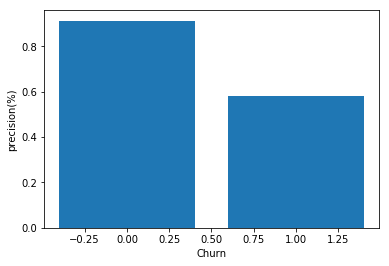

In [0]:
# 민감도 분석
a = []
for i in range(0,2):
    c = np.where((test['churn']==i) & (test['pred']==i), 1, 0).sum() / test[test['pred']==i]['churn'].count()
    a.append(c)

anp = np.array(a)
x = np.arange(0,2)
plt.bar(x,a)
plt.xlabel('Churn')
plt.ylabel('precision(%)')

In [0]:
a

[0.9129857190302225, 0.579041050172433]

In [0]:
# X_test를 기준으로 한 수치임
print('실제 비이탈자: ',test[test['churn']==0]['churn'].count())
print('예측 비이탈자(임계점 0.2): ',test[test['pred']==0]['pred'].count())
print('1차 제거될 비이탈자 비율 : ', test[test['pred']==0]['pred'].count() / test[test['churn']==0]['churn'].count())
# 총 이탈자의 3000명 정도를 92.3%의 민감도로 제거가 가능하다.

실제 비이탈자:  6533
예측 비이탈자(임계점 0.2):  3011
1차 제거될 비이탈자 비율 :  0.4608908617786622


In [0]:
# 이탈 예측 모델 저장
import pickle
pickle.dump(model2, open('/content/drive/My Drive/xgb_churn_0828.pickle.dat','wb'))

In [0]:
# 모델 로드
import pickle
churn_xgb = pickle.load(open('/content/drive/My Drive/xgb_churn_0828.pickle.dat','rb'))

In [0]:
# 이탈 예측을 40000명 대상으로 실시

In [0]:
# 임계값 조절
y_pred = np.where(churn_xgb.predict(xgb.DMatrix(act_40000_best.drop('acc_id',axis=1))) > 0.2, 1, 0)

In [0]:
churn_train = act_40000_best
churn_train['churn'] = y_pred
# 비이탈로 분류된 유저 제외
churn_set = churn_train[churn_train['churn']==1].drop('churn',axis=1)

In [0]:
# 10000aud 가량 제거
churn_set.shape

(29652, 129)

In [0]:
# 클래스 다시 정의
chrun_acc = churn_set[['acc_id']]
survival_time2 = pd.merge(survival_time, chrun_acc, on ='acc_id',how='inner')

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(churn_set, survival_time2['survival_time']-1, test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape,  X_valid.shape, y_valid.shape

((15567, 129), (8896, 129), (15567,), (8896,), (5189, 129), (5189,))

In [0]:
y_train.head()

6571     18
16210    63
9662     63
28741    63
16739     7
Name: survival_time, dtype: int64

In [0]:
survival_time2.loc[6571]

acc_id           28988
survival_time       19
Name: 6571, dtype: int64

In [0]:
import xgboost as xgb

params =   {
    'learning_rate': 0.02, 
    'gamma' : 0.3, 
    'min_child_weight' : 3,
    'nthread' : 15,
    'max_depth' : 30,
    'subsample' : 0.9,
    'eval_metric' : 'merror',
    'colsample_bytree' : 0.8, 
    'num_boost_round' : 500,
    'n_estimators': 500,
    'max_leaves': 300,
    'objective': 'multi:softprob',
    'num_class': 64
}

In [0]:
VALID = True
if VALID == True:

    tr_data = xgb.DMatrix(X_train, y_train)
    va_data = xgb.DMatrix(X_valid, y_valid)

    #del X_train, X_valid, y_train, y_valid  ; gc.collect()

    watchlist = [(tr_data, 'train'), (va_data, 'valid')]

    model = xgb.train(params, tr_data, 500, watchlist, maximize=False, 
                      early_stopping_rounds = 30, verbose_eval=50)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-merror:0.40907	valid-merror:0.418963
Multiple eval metrics have been passed: 'valid-merror' will be used for early stopping.

Will train until valid-merror hasn't improved in 30 rounds.
[50]	train-merror:0.367701	valid-merror:0.403931
[100]	train-merror:0.31631	valid-merror:0.400077
Stopping. Best iteration:
[108]	train-merror:0.305197	valid-merror:0.399692



In [0]:
import pickle
pickle.dump(model, open('/content/drive/My Drive/xgb_churn_surv_0828.pickle.dat','wb'))

In [0]:
# 모델 로드
import pickle
churn_xgb = pickle.load(open('/content/drive/My Drive/xgb_churn_surv_0828.pickle.dat','rb'))

In [0]:
# 테스트셋 예측
a_surv_pred = model.predict(xgb.DMatrix(X_test))

In [0]:
a_surv_pred

array([[0.00626639, 0.00481698, 0.00390707, ..., 0.0050134 , 0.00424064,
        0.574345  ],
       [0.00214757, 0.00243307, 0.00222316, ..., 0.00203351, 0.00208111,
        0.82382226],
       [0.00293814, 0.00423275, 0.00296868, ..., 0.00438835, 0.00341841,
        0.7286032 ],
       ...,
       [0.00657452, 0.01493135, 0.0080358 , ..., 0.00657106, 0.01059491,
        0.23583947],
       [0.01647489, 0.01065817, 0.70554626, ..., 0.00246287, 0.00237841,
        0.01195217],
       [0.00711602, 0.02298984, 0.0189347 , ..., 0.00633366, 0.00569972,
        0.33722928]], dtype=float32)

In [0]:
category_surv_pred = a_surv_pred.argmax(axis=1) +1

In [0]:
y_test2 = y_test +1

In [0]:
category_test = DataFrame(y_test2.values, columns=['survival_time'])
category_test['survival_pred'] = category_surv_pred

In [0]:
category_test.head()

,survival_time,survival_pred
0,64,64
1,64,64
2,62,64
3,64,64
4,64,64


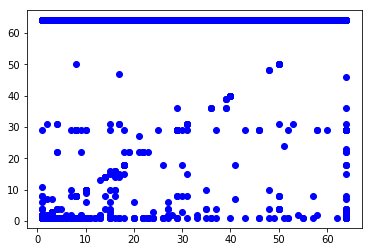

In [0]:
plt.plot(category_test['survival_time'],category_test['survival_pred'],'bo')

Booster 0.6015062949640287
precision=nan:  [4, 6, 7, 9, 11, 23, 24, 27, 46, 47]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


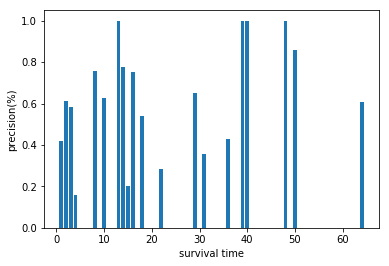

In [0]:
print(churn_xgb.__class__.__name__, accuracy_score(y_test2, category_surv_pred))

a = []
day = []
for i in range(1,65):
    c = np.where((category_test['survival_time']==i) & (category_test['survival_pred']==i), 1, 0).sum() / category_test[category_test['survival_pred']==i]['survival_pred'].count()
    a.append(c)
    if c < 0.2:
        day.append(i)
anp = np.array(a)
x = np.arange(1,65)
plt.bar(x,a)
plt.xlabel('survival time')
plt.ylabel('precision(%)')

print('precision=nan: ', day)
# recall 아니고 precision 그래프입니다. 

(array([ 648.,  533.,  415.,  532.,  523.,  275.,  262.,  230.,  217.,
        5261.]),
 array([ 1. ,  7.3, 13.6, 19.9, 26.2, 32.5, 38.8, 45.1, 51.4, 57.7, 64. ]),
 <a list of 10 Patch objects>)

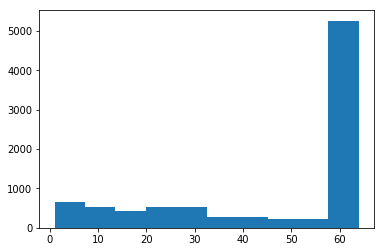

In [0]:
plt.hist(y_test2)

(array([4.120e+02, 7.700e+01, 3.100e+01, 1.600e+01, 1.390e+02, 7.000e+00,
        1.900e+01, 1.100e+01, 0.000e+00, 8.184e+03]),
 array([ 1. ,  7.3, 13.6, 19.9, 26.2, 32.5, 38.8, 45.1, 51.4, 57.7, 64. ]),
 <a list of 10 Patch objects>)

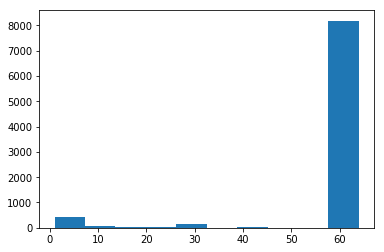

In [0]:
plt.hist(category_surv_pred)

In [0]:
a

In [0]:
day

[4, 6, 7, 9, 11, 23, 24, 27, 46, 47]

In [0]:
len(a_surv_pred)

8896

In [0]:
# xgb로 분류된 결과에서 prob를 기준으로 다시 진짜 잔존 유저만 도려냄
churn_clf  = a_surv_pred[a_surv_pred.argmax(axis=1) == 63]
churn_real64 = category_test[(category_test['survival_pred']==64)]

In [0]:
churn_clf[:,-1]

array([0.574345  , 0.82382226, 0.7286032 , ..., 0.54734904, 0.23583947,
       0.33722928], dtype=float32)

In [0]:
churn_real64['64_prob'] = churn_clf[:,-1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
churn_real64.head(20)

,survival_time,survival_pred,64_prob
0,64,64,0.574345
1,64,64,0.823822
2,62,64,0.728603
3,64,64,0.316335
4,64,64,0.528649
5,23,64,0.643663
6,59,64,0.351962
7,5,64,0.102197
9,64,64,0.790016
10,27,64,0.493857


(array([ 76., 192., 260., 332., 433., 496., 542., 716., 982., 954.]),
 array([0.05730665, 0.13765986, 0.21801308, 0.29836628, 0.3787195 ,
        0.4590727 , 0.5394259 , 0.6197791 , 0.70013237, 0.7804856 ,
        0.8608388 ], dtype=float32),
 <a list of 10 Patch objects>)

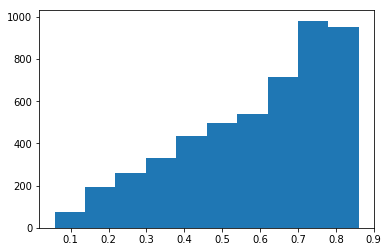

In [0]:
plt.hist(churn_real64[churn_real64['survival_time']>63]['64_prob'])

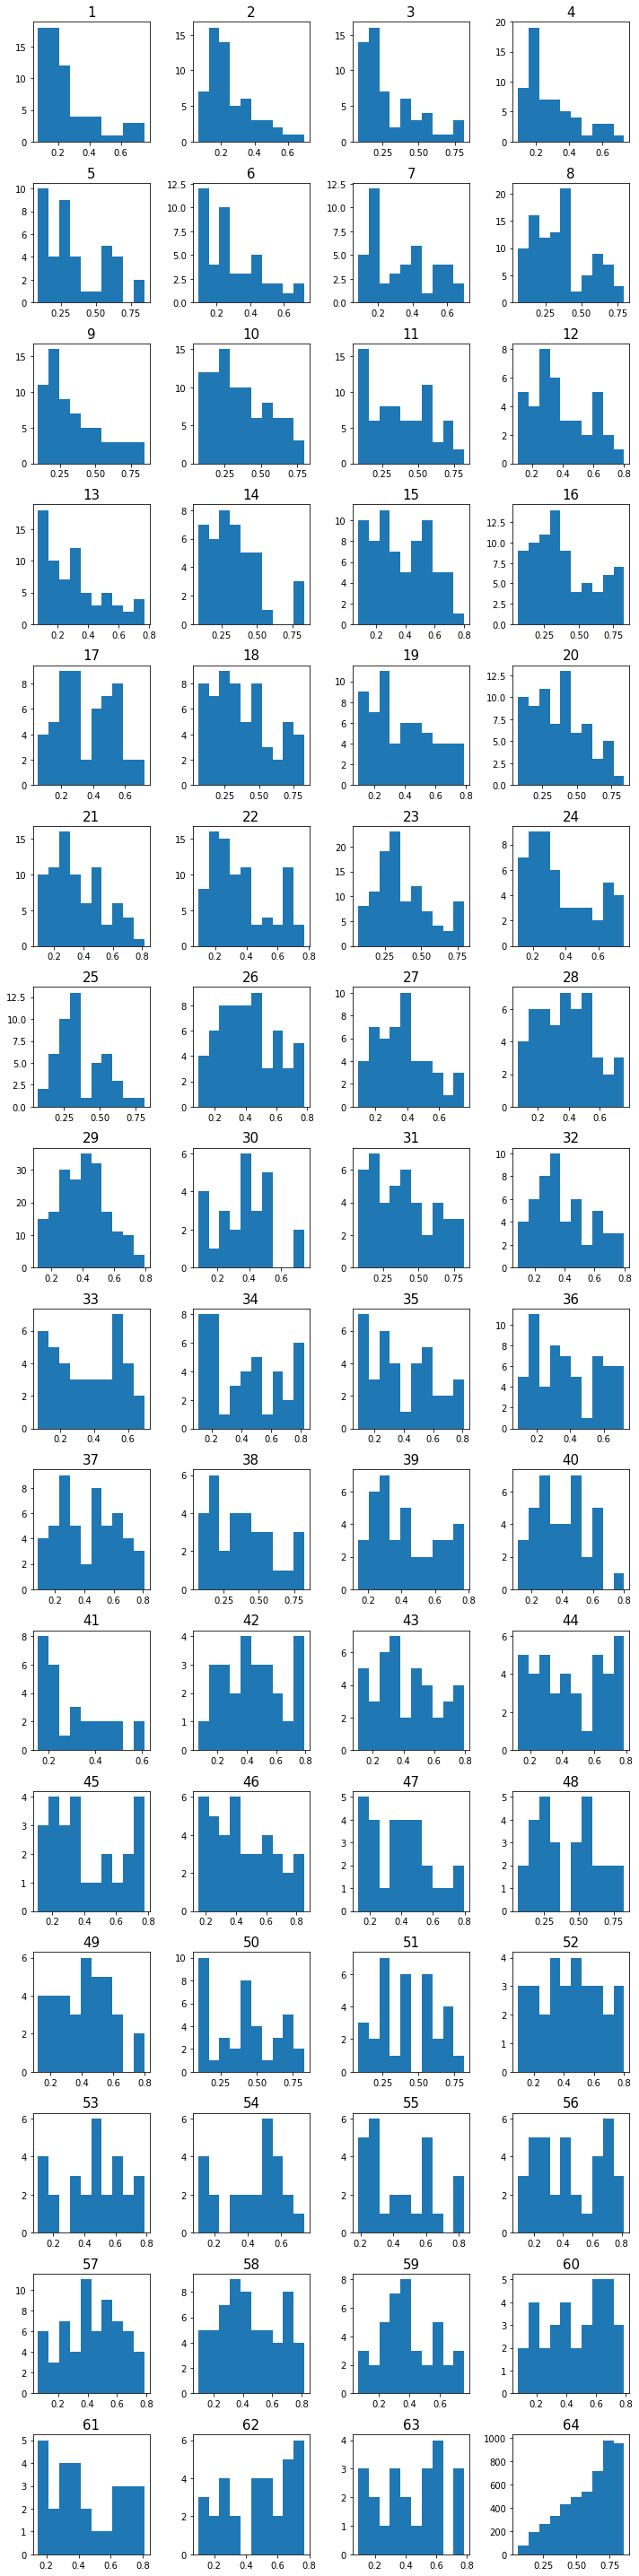

In [0]:
# 실제 생존기간이 10 이하인 유저의 64일 prob
fig = plt.figure(figsize=(10, 40), facecolor='w')
import sys
mod = sys.modules[__name__]
for i in range(1, 65):
  setattr(mod, 'ax{}'.format(i), fig.add_subplot(16, 4, i))
  getattr(mod, 'ax{}'.format(i)).hist(churn_real64[churn_real64['survival_time']==i]['64_prob'])
  getattr(mod, 'ax{}'.format(i)).set_title(i, fontsize=15)
plt.tight_layout()

In [0]:
#  누적 분포로 보기



# Xgb 총결제량 예측

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(act_40000_best[act_40000_best.columns[1:]], total_spent['total_spent'], test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape,  X_valid.shape, y_valid.shape

((21000, 128), (12000, 128), (21000,), (12000,), (7000, 128), (7000,))

In [0]:
import xgboost as xgb

params =   {
    'learning_rate': 0.02, 
    'gamma' : 0.3, 
    'min_child_weight' : 3,
    'nthread' : 15,
    'max_depth' : 30,
    'subsample' : 0.9,
    'eval_metric' : 'rmse',
    'colsample_bytree' : 0.8, 
    'num_boost_round' : 500,
    'n_estimators': 1000,
    'max_leaves': 300,
    'objective':'reg:squarederror'
}

In [0]:
VALID = True
if VALID == True:

    tr_data = xgb.DMatrix(X_train, y_train)
    va_data = xgb.DMatrix(X_valid, y_valid)

    #del X_train, X_valid, y_train, y_valid  ; gc.collect()

    watchlist = [(tr_data, 'train'), (va_data, 'valid')]

    model2 = xgb.train(params, tr_data, 500, watchlist, maximize=False, 
                      early_stopping_rounds = 30, verbose_eval=50)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-rmse:7.50978	valid-rmse:7.4532
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[50]	train-rmse:3.80026	valid-rmse:5.75083
[100]	train-rmse:2.08888	valid-rmse:5.41254
[150]	train-rmse:1.25685	valid-rmse:5.36782
Stopping. Best iteration:
[164]	train-rmse:1.11088	valid-rmse:5.36631



In [0]:
import pickle
pickle.dump(model2, open('/content/drive/My Drive/xgb_total_0828.pickle.dat','wb'))

In [0]:
import pickle
total_xgb = pickle.load(open('/content/drive/My Drive/xgb_total_0828.pickle.dat','rb'))

In [0]:
total_pred = total_xgb.predict(xgb.DMatrix(X_test))

In [0]:
type(y_test)

pandas.core.series.Series

In [0]:
total_test = DataFrame(y_test.values, columns=['total_real'])
total_test['total_pred'] = total_pred

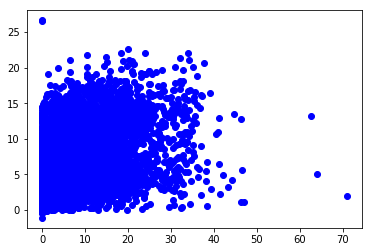

In [0]:
plt.plot(total_test['total_real'], total_test['total_pred'], 'bo')

# xgb 생존기간 예측 

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(act_40000_best[act_40000_best.columns[1:]], survival_time['survival_time']-1, test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape,  X_valid.shape, y_valid.shape

((21000, 128), (12000, 128), (21000,), (12000,), (7000, 128), (7000,))

In [0]:
len(set(y_train))

64

In [0]:
import xgboost as xgb

params =   {
    'learning_rate': 0.02, 
    'gamma' : 0.3, 
    'min_child_weight' : 3,
    'nthread' : 15,
    'max_depth' : 30,
    'subsample' : 0.9,
    'eval_metric' : 'merror',
    'colsample_bytree' : 0.8, 
    'num_boost_round' : 500,
    'n_estimators': 475,
    'max_leaves': 300,
    'objective': 'multi:softprob',
    'num_class': 64
}

In [0]:
np.random.seed(42)
import pickle
import matplotlib.pyplot as plt

VALID = True
if VALID == True:

    tr_data = xgb.DMatrix(X_train, y_train)
    va_data = xgb.DMatrix(X_valid, y_valid)

    #del X_train, X_valid, y_train, y_valid  ; gc.collect()

    watchlist = [(tr_data, 'train'), (va_data, 'valid')]

    model2 = xgb.train(params, tr_data, 500, watchlist, maximize=False, 
                      early_stopping_rounds = 30, verbose_eval=50)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-merror:0.409095	valid-merror:0.415286
Multiple eval metrics have been passed: 'valid-merror' will be used for early stopping.

Will train until valid-merror hasn't improved in 30 rounds.
[50]	train-merror:0.335714	valid-merror:0.378286
[100]	train-merror:0.277762	valid-merror:0.37
[150]	train-merror:0.205333	valid-merror:0.367429
[200]	train-merror:0.129762	valid-merror:0.366429
[250]	train-merror:0.069095	valid-merror:0.365
[300]	train-merror:0.033333	valid-merror:0.364286
Stopping. Best iteration:
[290]	train-merror:0.038667	valid-merror:0.363571



In [0]:
y_pred = xg_reg.predict(X_test)


predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

surv_pred = np.array(predictions)

xt= y_test.reset_index()
xt['survival_pred'] = surv_pred

xa = []
for i in range(1,65):
    xc = np.where((xt['survival_time']==i) & (xt['survival_pred']==i), 1, 0).sum() / xt[xt['survival_pred']==i]['index'].count()
    xa.append(xc)

xanp = np.array(xa)
x = np.arange(1,65)
plt.bar(x,xa)
plt.xlabel('survival time')
plt.ylabel('recall(%)')

pickle.dump(xg_reg, open('/content/drive/My Drive/xgb_surv.pickle.dat','wb'))

NameError: ignored

In [0]:
act_40000_best = pd.read_csv('/content/drive/My Drive/train_allfeature.csv')

# 이탈 유저만을 예측

In [0]:
churn_user = survival_time[survival_time['survival_time']!=64]
churn_user = pd.merge(act_40000_best, churn_user, on='acc_id', how='inner')
churn_survival = survival_time[survival_time['survival_time']!=64]
churn_user= churn_user.drop('survival_time',axis=1)

In [0]:
churn_user.shape

(18004, 129)

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(churn_user[churn_user.columns[1:]], churn_survival['survival_time'], test_size=0.3, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12602, 128), (5402, 128), (12602,), (5402,))

In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor


rnd_clf = RandomForestClassifier(n_estimators=700,random_state=42, criterion = 'entropy')
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)

xt= y_test.reset_index()
xt['survival_pred'] = y_pred

xa = []
for i in range(1,65):
    xc = np.where((xt['survival_time']==i) & (xt['survival_pred']==i), 1, 0).sum() / xt[xt['survival_time']==i]['index'].count()
    xa.append(xc)

xanp = np.array(xa)
x = np.arange(1,65)
plt.bar(x,xa)
plt.xlabel('survival time')
plt.ylabel('recall(%)')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in long_scalars
  after removing the cwd from sys.path.


Text(0, 0.5, 'recall(%)')

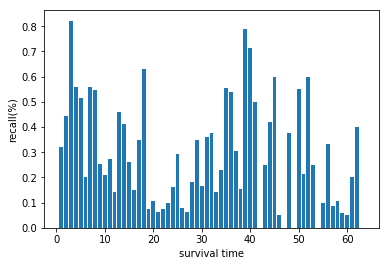

In [0]:
import matplotlib.pyplot as plt
xa = []
for i in range(1,65):
    xc = np.where((xt['survival_time']==i) & (xt['survival_pred']==i), 1, 0).sum() / xt[xt['survival_pred']==i]['index'].count()
    xa.append(xc)

xanp = np.array(xa)
x = np.arange(1,65)
plt.bar(x,xa)
plt.xlabel('survival time')
plt.ylabel('recall(%)')

In [0]:
import pickle
xgb_survival_time1 = pickle.load(open("xgb_survival1(scale).pickle.dat", "rb"))

C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [0]:
# 예측
data_for_surv = data_
surv_pred = xgb_survival_time1.predict(data_for_surv)

In [0]:
# test 데이터 불러와서 예측값 바꾸기
test1 = pd.read_csv('test1_predict.csv')

In [0]:
test1['total_spent'] = test1['amount_spent'] * test1['survival_time']
test1['survival_time'] = surv_pred
test1['amount_spent'] = test1['total_spent'] / test1['survival_time']

test1 = test1.drop('total_spent',axis=1)

In [0]:
test1.to_csv('./test1_predict(scale_both).csv', index=False)

# 랜덤포레스트

In [0]:
act_40000_best2.columns

Index(['acc_id', 'class', 'temp_cnt', 'private_shop', 'level', 'party_exp',
       'pledge_cnt', 'random_attacker_cnt', 'random_defender_cnt',
       'same_pledge_cnt', 'etc_cnt', 'num_opponent', 'playtime', 'npc_kill',
       'solo_exp', 'quest_exp', 'rich_monster', 'death', 'revive',
       'exp_recovery', 'fishing', 'game_money_change', 'enchant_count',
       'forgive', 'pledge_cnt_count', 'random_attacker_cnt_count',
       'random_defender_cnt_count', 'temp_cnt_count', 'same_pledge_cnt_count',
       'etc_cnt_count', 'num_opponent_count', 'playtime_count',
       'npc_kill_count', 'solo_exp_count', 'party_exp_count',
       'quest_exp_count', 'rich_monster_count', 'death_count', 'revive_count',
       'exp_recovery_count', 'fishing_count', 'private_shop_count',
       'game_money_change_count', 'enchant_count_count', 'stop', 'day_pledge',
       'day_attack', 'day_defend', 'day_temp', 'day_same', 'day_etc',
       'std_pledge', 'std_attack', 'std_defend', 'std_temp', 'std_same',


In [0]:
data_for_total = data_
total_pred = rnd_clf.predict(data_for_total)

NameError: name 'rnd_clf' is not defined

In [0]:
c = train_label[['acc_id','total_spent']].sort_values('acc_id')
c['total_pred'] = total_pred
plt.figure(figsize=(20,15))
plt.plot(c['total_pred'], c['total_spent'], 'bo')

In [0]:
# load model from file
import pickle
rnd_amount_spent1 = pickle.load(open("rnd_total_spent1(scale).pickle.dat", "rb"))

C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.21.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


test 데이터 적용

In [0]:
data_.shape

(20000, 70)

In [0]:
data_for_total = data_
total_pred = rnd_amount_spent1.predict(data_for_total)

In [0]:
test1 = pd.read_csv('test2_predict.csv')

In [0]:
test1['total_spent'] = total_pred
test1['amount_spent'] = test1['total_spent'] / test1['survival_time']
test1 = test1.drop('total_spent',axis=1)
test1.to_csv('./test2_predict(scale).csv', index=False)

In [0]:
#  결론

일단 총결제량만 일별 정규화해봤더니 훈련데이터에서는 비슷한 기대이익이 나왔으나, test에서는 오히려 떨어짐..
생존기간까지 이걸로 해보고 다시 도전..

1) 둘 다 일펼 정규화 후에 제출했더니 점수 1900점 대로 매우 떨어짐